In [1]:
%cd ..

/workspace/shai_hulud/ppc_experiments


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/ppc_minibmnist_config.json")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
trainer.fit(model, data, ckpt_path="saved/models/MiniBouncingMnist_Ppc/0619_185129/checkpoint_999.ckpt")

Missing logger folder: saved/log/MiniBouncingMnist_Ppc/0621_154255/lightning_logs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /workspace/shai_hulud/ppc_experiments/saved/models/MiniBouncingMnist_Ppc/0621_154255 exists and is not empty.
Restoring states from the checkpoint path at saved/models/MiniBouncingMnist_Ppc/0619_185129/checkpoint_999.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:361: The dirpath has changed from '/workspace/shai_hulud/ppc_experiments/saved/models/MiniBouncingMnist_Ppc/0619_185129' to '/workspace/shai_hulud/ppc_experiments/saved/models/MiniBouncingMnist_Ppc/0621_154255', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name       | Type             | Params
------------------

Sanity Checking: |                                                                                            …

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [6]:
model.graph.clear()
model.eval()
model.cuda()

LightningPpc(
  (graph): BouncingMnistPpc(
    (decoder): DigitsDecoder(
      (decoder): Sequential(
        (0): Linear(in_features=10, out_features=200, bias=True)
        (1): ReLU()
        (2): Linear(in_features=200, out_features=400, bias=True)
        (3): ReLU()
        (4): Linear(in_features=400, out_features=784, bias=True)
        (5): Sigmoid()
      )
    )
    (digit_features): DigitFeatures()
    (digit_positions): DigitPositions(
      (dynamics): Sequential(
        (0): Linear(in_features=6, out_features=10, bias=True)
        (1): ReLU()
        (2): Linear(in_features=10, out_features=10, bias=True)
        (3): ReLU()
        (4): Linear(in_features=10, out_features=6, bias=True)
      )
    )
  )
  (predictive): Predictive()
)

In [7]:
import matplotlib.pyplot as plt

In [8]:
xs, _, indices = list(data.val_dataloader())[0]

In [9]:
xs.shape

torch.Size([96, 20, 96, 96])

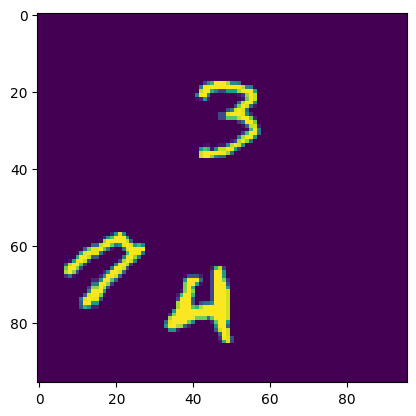

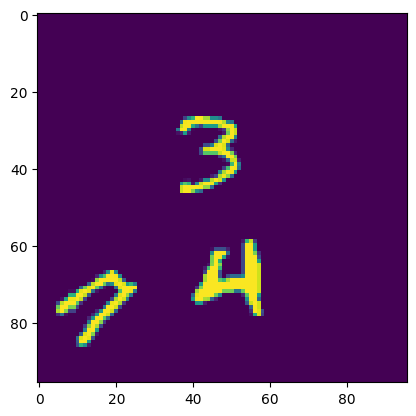

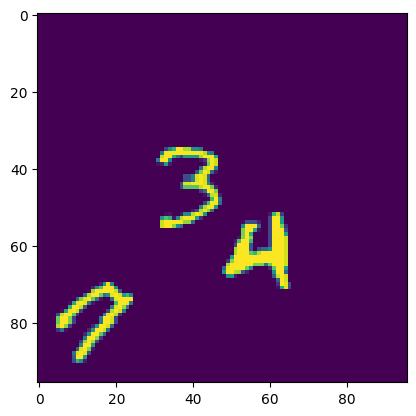

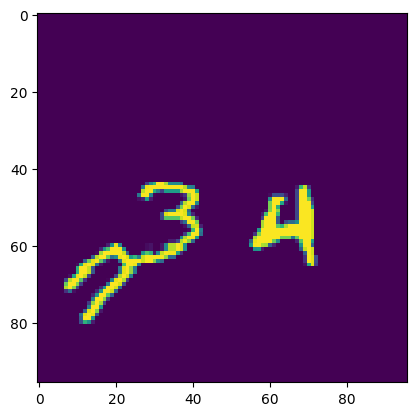

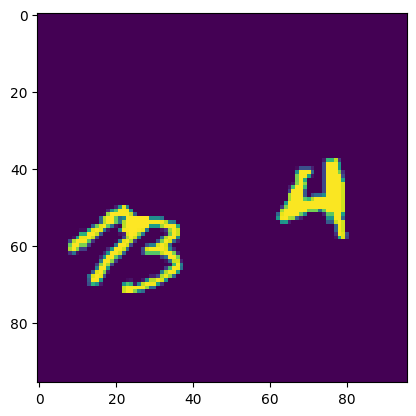

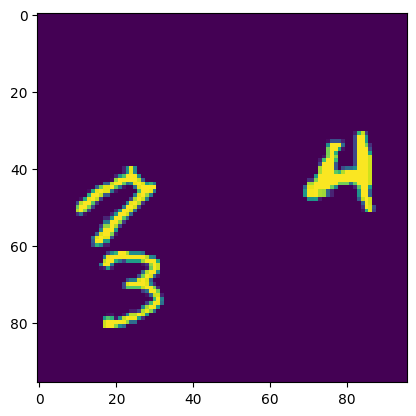

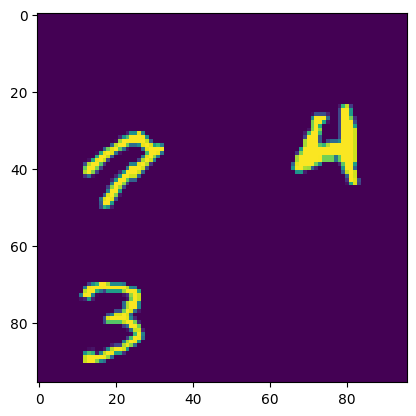

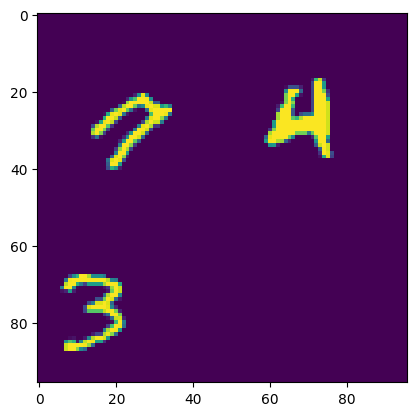

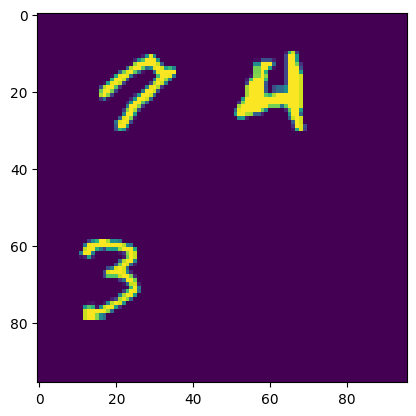

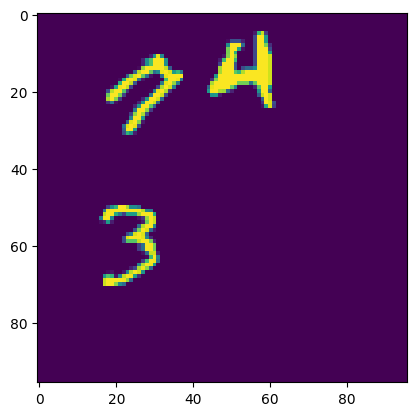

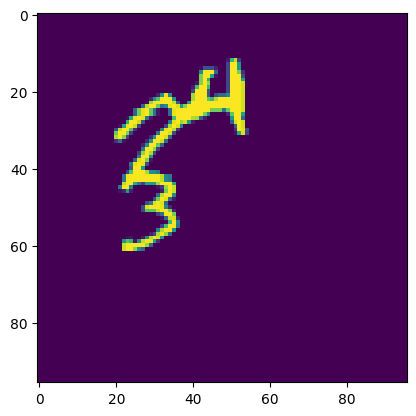

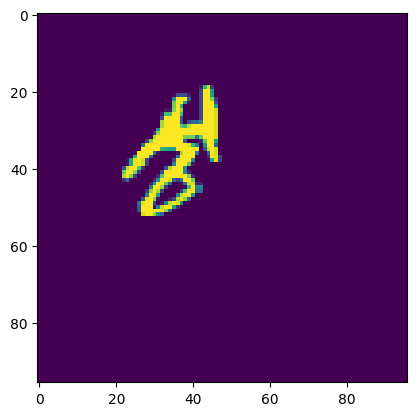

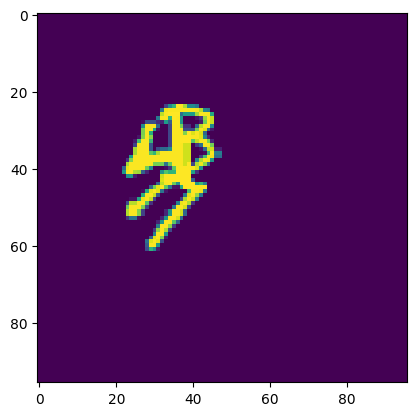

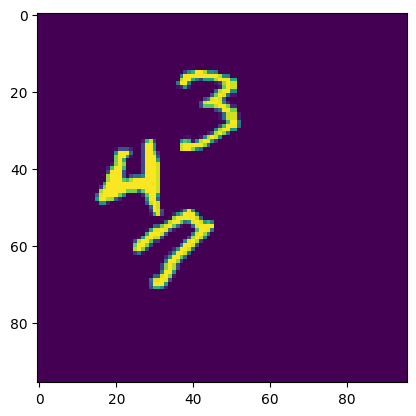

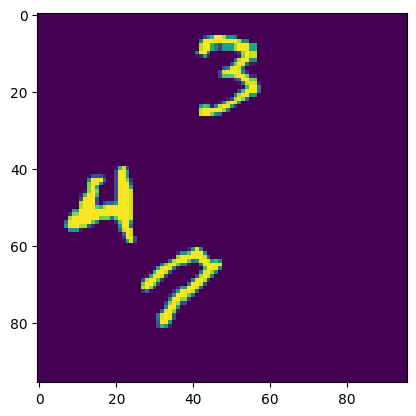

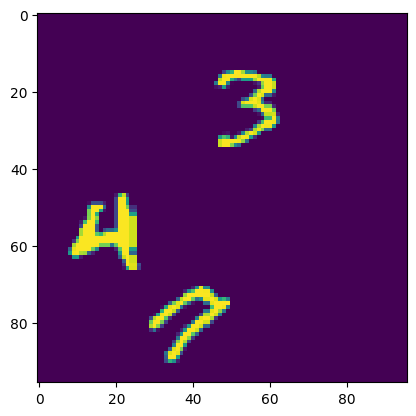

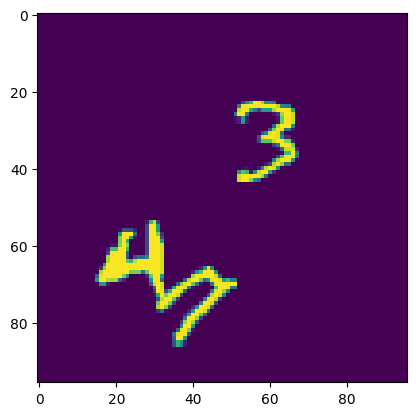

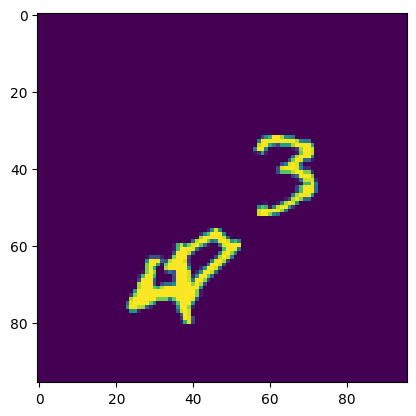

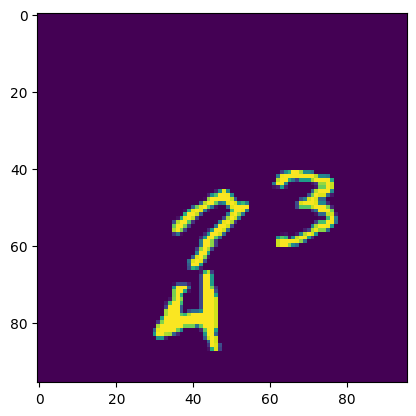

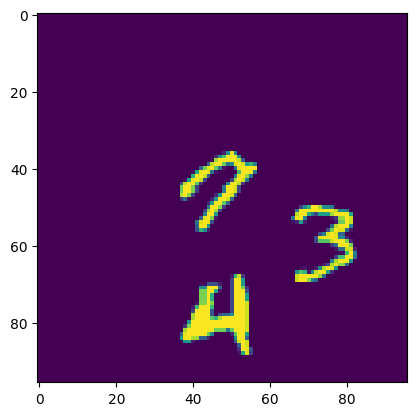

In [10]:
for t in range(xs.shape[1]):
    plt.imshow(xs[0, t, :, :])
    plt.show()

In [11]:
model._load_particles(indices, False)

In [12]:
with model.graph.condition(**{k: v['value'] for k, v in model.graph.nodes.items()}) as predictive:
    estimates = predictive(B=len(xs), mode="prior", P=model.num_particles)

In [13]:
estimates = torch.stack(estimates, dim=-3)

In [14]:
estimate = estimates.mean(dim=0)[0]

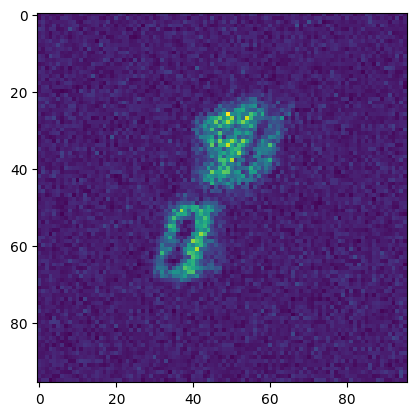

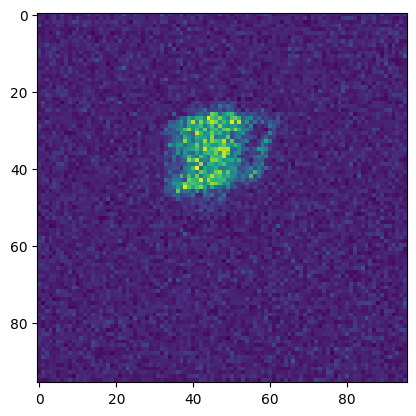

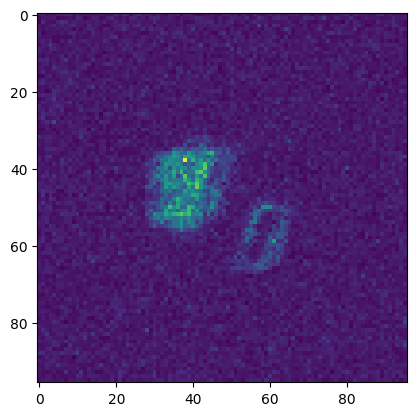

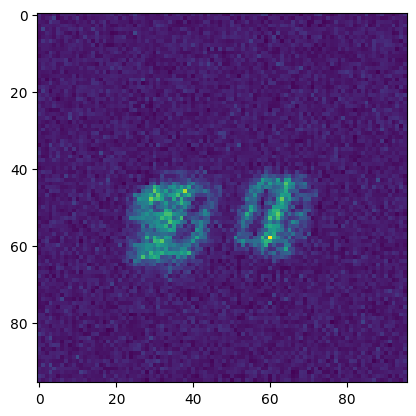

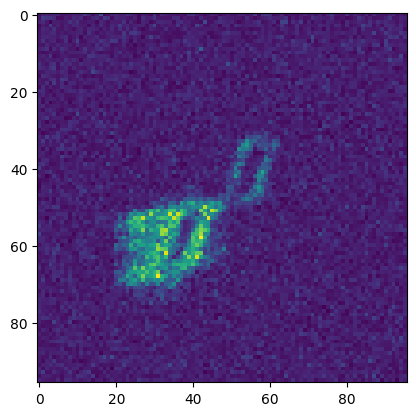

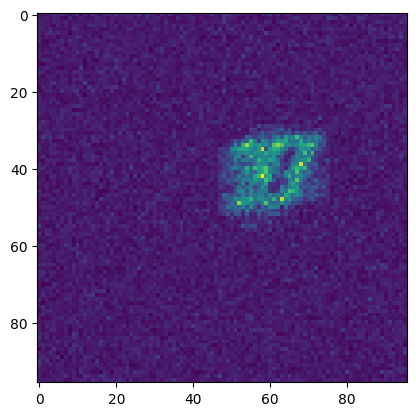

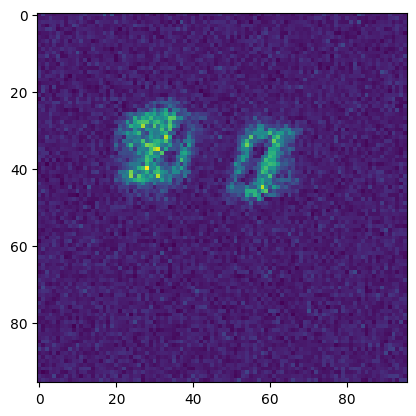

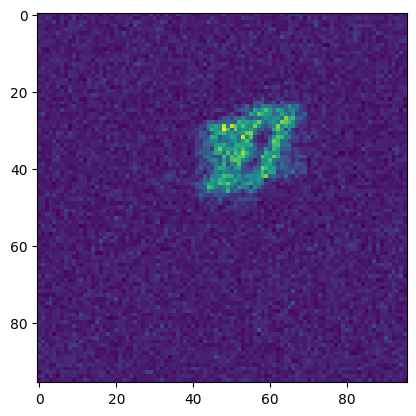

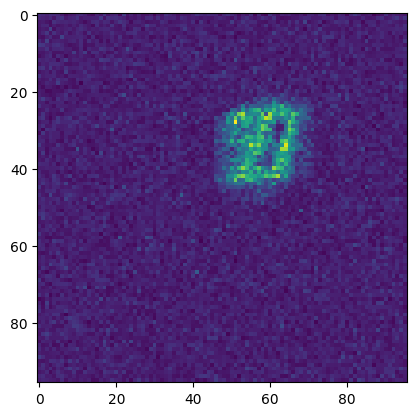

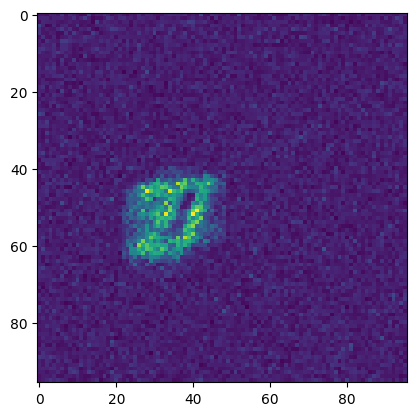

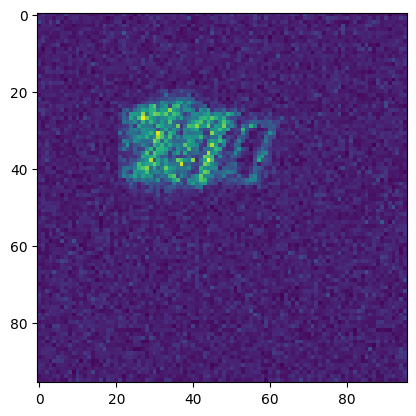

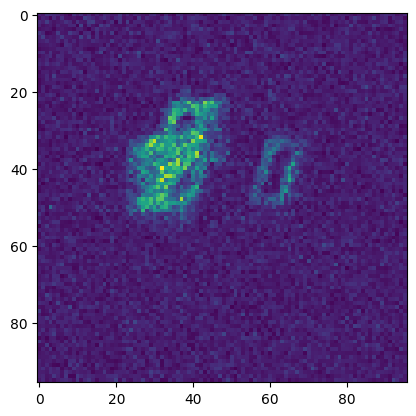

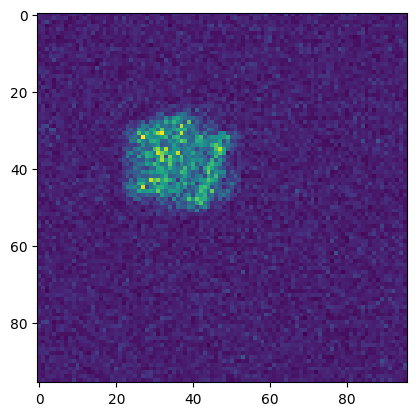

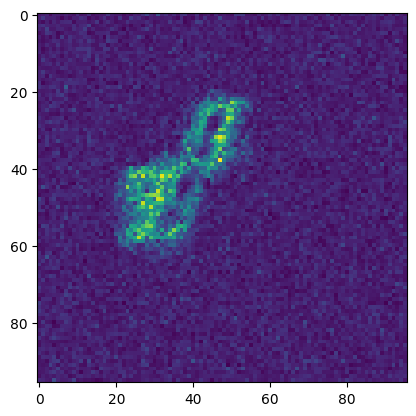

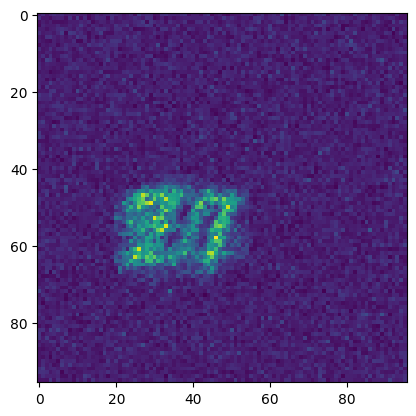

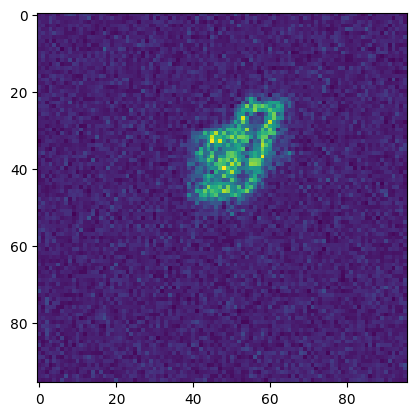

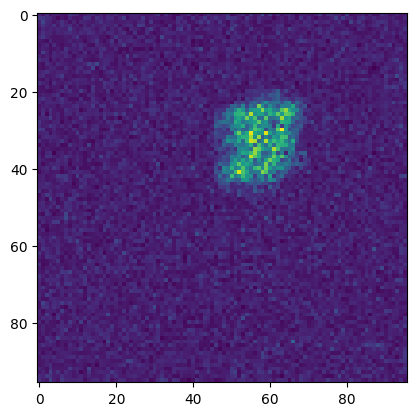

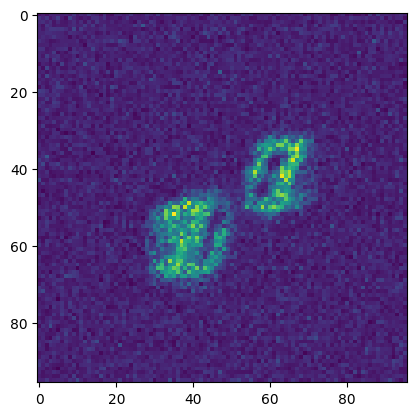

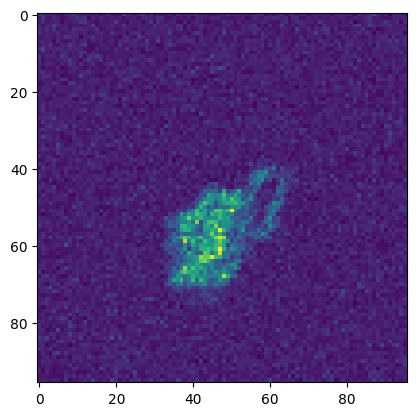

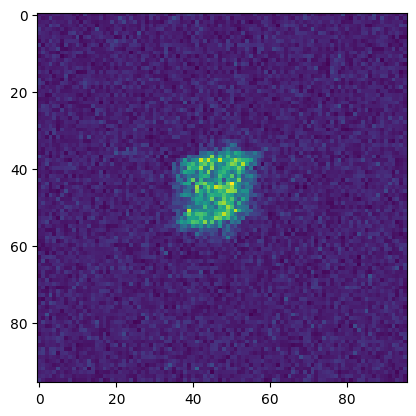

In [15]:
for t in range(estimate.shape[0]):
    plt.imshow(estimate[t, :, :].detach().cpu().numpy())
    plt.show()